In [2]:
from typing import TypedDict, Annotated, List, Dict
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from langchain_openai.chat_models.base import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage, RemoveMessage

from dotenv import load_dotenv
from langsmith import Client

from langgraph.checkpoint.memory import MemorySaver
from langchain_core.runnables import RunnableConfig

load_dotenv() 
client = Client() # langsmith 추적

config = RunnableConfig(
    recursion_limit=10,  # 최대 10개의 노드까지 방문. 그 이상은 RecursionError 발생
    configurable={"thread_id": "2"},  # 스레드 ID 설정
    tags=["랭그래프설계(5)"],  # Tag
)
memory = MemorySaver()

class RealEstateState(TypedDict): # 그래프의 상태를 정의하는 클래스
    real_estate_type: Annotated[str ,"부동산 유형 (예: 아파트, 상가)"]
    keywordlist: Annotated[List[Dict] ,"키워드 리스트"]
    messages: Annotated[list, add_messages]
    summary: Annotated[str, "길어진 메세지 요약"]
    query_sql: Annotated[str ,"생성된 SQL 쿼리"]
    results: Annotated[List[Dict], "쿼리 결과"]
    answers: Annotated[List[str], "최종 답변 결과"]
    query_answer:Annotated[str, 'answer다듬기']

# Step 1: LLM 초기화
llm = ChatOpenAI(model="gpt-4o-mini", temperature=1)

# Step 2: StateGraph 정의
workflow = StateGraph(RealEstateState)

In [3]:
def filter_node(state:RealEstateState) -> RealEstateState:
    print("[Filter Node] AI가 질문을 식별중입니다!!!!")
    system_prompt = """
    Classify if a given question is related to real estate. If the question is related to topics such as property transactions, rental conditions, location recommendations, or property features, return Pass. If it's not directly related to real estate, return Fail.

    # Output Format
    - Return Pass if the question is real estate-related, otherwise return Fail.

    # Examples
    - 입력: '서울 아파트 매매 가격이 어떻게 되나요?'
      출력: Pass

    - 입력: '이 동네 전세 시세 알려주세요'
      출력: Pass

    - 입력: '서울에서 월세 계약 조건이 어떻게 되나요?'
      출력: Pass

    - 입력: '서울 아파트 매매가 얼마인가요?'
      출력: Pass

    - 입력: '대치동에서 버스정류장과 지하철이 가장 가까운 곳으로 알려줘'
      출력: Pass

    - 입력: '여자 혼자 살기 좋은 곳 추천해줘'
      출력: Pass

    - 입력: '교통이 편리하고 저렴한 원룸 추천해줘'
      출력: Pass

    - 입력: '이 음식점이 맛있나요?'
      출력: Fail

    - 입력: '서울에서 가장 큰 공원이 어디인가요?'
      출력: Fail
    """

    summary = state.get("summary", "")
    if summary:

        # Add summary to system message
        summary_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = summary_message + state["messages"][-1].content

    else:
        messages = state["messages"][-1].content

    response = llm.invoke([
        SystemMessage(content=system_prompt),
        HumanMessage(messages)
    ])

    real_estate_type = response.content.strip()
    print("[Filter Node] AI가 질문을 식별했습니다.")
    return {"real_estate_type": real_estate_type, "messages": messages}

def summarize_conversation(state: RealEstateState):
    summary = state.get("summary", "")
    if summary:
        summary_prompt = (
            f"현재까지의 대화 요약: {summary}\n\n"
            "위의 새로운 메시지를 고려하여 요약을 확장하세요:"
        )
    else:
        summary_prompt = "위의 대화를 요약하세요:"

    messages = state["messages"] + [HumanMessage(content=summary_prompt)]
    response = llm.invoke(messages)

    # 최근 2개의 메시지만 남기고 이전 메시지 삭제
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

    
def should_summarize(state: RealEstateState) :
    if len(state["messages"]) > 6:
        return "summarize_conversation"
    return "Filter Question"

def fiter_router(state: RealEstateState):
    # This is the router
    real_estate_type = state["real_estate_type"]
    if real_estate_type == "Pass":
        return "Pass"
    else:
        return 'Fail'
    
def re_questions(state: RealEstateState) -> RealEstateState:
    print("=================================")
    print("""[re_questions] 질문이 부동산 관련이 아니거나 제대로 인식되지 않았습니다.
          부동산 관련 질문을 좀 더 자세하게 작성해주시면 답변드리겠습니다!!!""")
    new_question = input("새로운 부동산 질문을 입력해주세요:  ")
    print("=================================")
    # 수정된 질문을 state에 업데이트
    return {"messages": new_question}


from sqlalchemy import create_engine
from sqlalchemy.pool import NullPool
from sqlalchemy.sql import text
from langchain.sql_database import SQLDatabase

def get_db_engine(user, password, host, port, database):
    """PostgreSQL DB와 연결된 엔진을 생성합니다."""
    try:
        # SQLAlchemy 엔진 생성 (PostgreSQL)
        engine = create_engine(
            f"postgresql://{user}:{password}@{host}:{port}/{database}",
            poolclass=NullPool  # 커넥션 풀링 비활성화 (단일 연결 사용)
        )
        return engine
    except Exception as e:
        print(f"데이터베이스 연결 중 오류 발생: {str(e)}")
        return None

# PostgreSQL 접속 정보
DB_CONFIG = {
    "user": "postgres",     # PostgreSQL 사용자 이름
    "password": "1234", # PostgreSQL 비밀번호
    "host": "localhost",         # PostgreSQL 서버 주소 (Docker 사용 시 컨테이너 이름 가능)
    "port": "5432",              # PostgreSQL 포트 (기본 5432)
    "database": "real_estate"    # 사용할 데이터베이스 이름
}

# PostgreSQL 엔진 생성
engine = get_db_engine(**DB_CONFIG)

# LangChain SQLDatabase 객체 생성
db = SQLDatabase(
    engine,
    sample_rows_in_table_info=False  # 샘플 행 조회 비활성화
)

In [4]:
db

In [5]:
# def generate_query(state: RealEstateState) -> RealEstateState:
#     print("[generate_query] 열심히 데이터베이스 쿼리문을 작성중입니다...")
#     table = db.get_table_info(table_names=["addresses","sales", "rentals", "property_info", "property_locations","location_distances", "subway_stations"])
#     prompt = f"""
#     다음 데이터베이스 구조를 기반으로 사용자의 질문에 대한 SQL 쿼리를 생성해주세요:
    
#     테이블 및 주요 컬럼 설명:
#     {table}

#     거리 및 대중교통 관련 계산 규칙:
#     - **대중교통과 매물간의 거리 계산**: 테이블들을 활용해서 계산합니다.

#     주의사항:
#     1. 관련 조건은 SQL WHERE 절 형식으로 작성해주세요.
#     2. '최근 5년' 같은 상대적 시간 표현은 현재 날짜 기준으로 변환해주세요.
#     3. '추천할 만한', '인기 있는' 등의 표현은 적절히 해석하여 조건을 추가해주세요. 예: 'crime_rate < 5' 또는 'population_level = "높음"'.
#     4. 텍스트 검색에는 LIKE 또는 MATCH ... AGAINST를 활용하세요.
#     5. 여러 조건은 AND 또는 OR로 연결하세요.
#     6. 정렬, 그룹화 등이 필요한 경우 이를 추가로 명시하세요. 예: ORDER BY created_at DESC.
#     7. 매물들을 정렬할 때 우선순위는 위치(1순위), 가격(2순위) 순 입니다.
#     8. 쿼리만 작성하고 추가 설명은 하지 마세요.
#     9. rental_type 값은 다음과 같습니다:
#         - 'MONTHLY': 전세
#         - 'YEARLY': 월세
#     10. facilities는 영어로 쳐야지 나옵니다.
#         - pi.facilities LIKE '%ELEVATOR%' -> 엘리베이터
#         - pi.facilities LIKE '%aircon%' -> 에이컨, 에어콘
#     11. 매물번호도 함께 보여주세요 매물번호는 property_id입니다.
#     12. rentals 테이블에 price라는 컬럼이 없습니다. rentals 테이블에는 price 대신 deposit(보증금)과 monthly_rent(월세) 컬럼이 존재합니다.
#     13. 지하철역에 관한 정보는 addresses 테이블의 area_name 칼럼에 있습니다.
#         - addresses.area_name LIKE '%강남역%' -> 강남역
#     14. subway_stations 테이블에는 지하철역이 아닌 지하철이 몇호선인지가 담겨있습니다.
#     15. subway_stations 테이블은 지하철 호선을 묻지를 않는 이상 절대로 사용하지 않습니다.
#     16. "역세권"은 location_distances 테이블의 distance를 사용하면 됩니다.
#         사용방법:
#         - location_distances 테이블의 address_id를 활용해서 관련 역을 찾습니다.
#         - location_distances 테이블의 property_location_id를 활용해서 관련 매물을 찾습니다.
#         - location_distances 테이블의 distance는 단위가 m(미터)입니다.

#     사용자 질문: {state['messages'][-1].content}

#     SQL 쿼리 형식:
#     SELECT * FROM table_name WHERE condition1 AND condition2 ...;
#     """

#     response = llm.invoke([
#             SystemMessage(content="당신은 SQLite Database  쿼리를 생성하는 전문가입니다."),
#             HumanMessage(prompt)
#         ])
#     print('[generate_query]: 쿼리문을 생성했습니다!')
    
#     return RealEstateState(query_sql=response.content)

In [6]:
import json

def extract_keywords_based_on_db(state: RealEstateState) -> RealEstateState:
    system_prompt = """
    Extract relevant keywords from a user's question based on the database schema. Match the keywords to the following categories and their corresponding tables/columns:

    1. **Location**:
    - Table: `Location`
    - Columns: `sido`, `sigungu`, `dong`

    2. **Property Type**:
    - Table: `Property`
    - Column: `property_type` (e.g., apartment, villa, officetel)

    3. **Price**:
    - Tables: `Sale`, `Rental`
    - Columns: `price`, `deposit`, `monthly_rent`

    4. **Transaction Type**:
    - Tables: `Sale`, `Rental`
    - Columns: `rental_type` (e.g., 매매, 전세, 월세)

    5. **Property Features**:
    - Table: `Property`
    - Columns: `room_count`, `bathroom_count`, `parking_count`, `exclusive_area`, `floor`

    6. **User Preferences**:
    - Table: `User`
    - Columns: `desired_location`, `age`, `gender`

    7. **Cultural/Facilities**:
    - Tables: `Cultural Facility`, `Cultural Festival`
    - Columns: `facility_name`, `festival_name`

    8. **Safety and Crime Data**:
    - Table: `Crime Stats`
    - Columns: `crime_category`, `crime_rate`

    # Output Format
    Return the extracted keywords in JSON format with the following keys:
    - "Location"
    - "Property Type"
    - "Price"
    - "Transaction Type"
    - "Property Features"
    - "User Preferences"
    - "Cultural/Facilities"
    - "Safety and Crime Data"

    If a category is not mentioned, return "없음".

    # Examples
    - Input: "서울 강남구에 있는 3억 이하 전세 아파트 찾아줘"
    Output: {
        "Location": "서울 강남구",
        "Property Type": "아파트",
        "Price": "3억 이하",
        "Transaction Type": "전세",
        "Property Features": "없음",
        "User Preferences": "없음",
        "Cultural/Facilities": "없음",
        "Safety and Crime Data": "없음"
    }

    - Input: "용산구에서 안전한 주택 찾고 싶어요"
    Output: {
        "Location": "용산구",
        "Property Type": "주택",
        "Price": "없음",
        "Transaction Type": "없음",
        "Property Features": "없음",
        "User Preferences": "없음",
        "Cultural/Facilities": "없음",
        "Safety and Crime Data": "안전"
    }

    - Input: "화장실 2개, 방 3개 있는 집 알려줘"
    Output: {
        "Location": "없음",
        "Property Type": "없음",
        "Price": "없음",
        "Transaction Type": "없음",
        "Property Features": "화장실 2개, 방 3개",
        "User Preferences": "없음",
        "Cultural/Facilities": "없음",
        "Safety and Crime Data": "없음"
    }
    """

    response = llm.invoke([
        SystemMessage(content=system_prompt),
        HumanMessage(content=state["messages"][-1].content)
    ])
    
    extracted_keywords = response.content.strip()
    result = json.loads(extracted_keywords)
    return RealEstateState(keywordlist=result)



In [7]:
base_prompt = """
다음 데이터베이스 구조를 기반으로 사용자의 질문에 대한 SQL 쿼리를 생성해주세요:

사용가능한 데이터 베이스 스키마:
{table}

### 제약조건
- SQL Query를 작성할 때 **반드시** Postgres SQL문법을 지켜라.
- SQL Query를 작성할 때 **반드시** 최적화된 Query를 작성하라.
- SQL Query를 작성할 때 **반드시** 제공된 테이블 이름만 사용하라.
- SQL Query를 작성할 때 **반드시** 제공된 컬럼 이름만 사용하라.
- SQL Query를 작성할 때 **반드시** 주어진 테이블의 관계를 고려하라.
- SQL Query를 작성할 때 **반드시** 제약 조건을 지켜라.


### 테이블/컬럼 설명 및 관계
- 'addresses' : 주소의 id와 이름, 좌표 정보를 담고 있는 테이블, 'address_id'는 'location_distances'테이블과 'property_locations'테이블과 연결된다. 'area_name'은 지하철역, 편의시설, 축제 등의 이름이다.
- 'location_distances' : 주소 간의 거리 정보를 담고 있는 테이블, 'id'는 'property_info'테이블과 'addresses'테이블과 연결된다.
- 'rentals' : 임대 매물의 정보를 담고 있는 테이블
- 'sales' : 매매 매물의 정보를 담고 있는 테이블
- 'property_info' : 매물의 정보를 담고 있는 테이블, 'property_id'는 'sales'테이블과 'rentals'테이블과 연결된다.


### 영어 키워드
- 'facilities'에 관련된 Query는 영어로 작성해야한다.
  ex) 엘리베이터 -> WHERE pi.facilities LIKE '%ELEVATOR%', 에어컨 -> WHERE pi.facilities LIKE '%aircon%'
- 주택 유형(아파트, 빌라, 오피스텔 등)에 관련된된 Query는 영어로 작성해야한다.
  ex) pi.property_type LIKE '%APARTMENT%' -> 아파트, pi.property_type LIKE '%COMMERCIAL%' -> 상가

  
### 거리 관련 요청
- 모든 거리에 대한 요청은 m단위로 계산하라. ex) 1km -> 1000m
- 거리에 대한 요청은 우선적으로 'location_distances'테이블을 참고하라. 'distances'는 'property_id'를 기준으로 반경 1000m 이내에 있는 'address_id'와의 거리를 나타낸다.
- 'location_distances'테이블에 관련 정보가 없는 경우에는 'addresses'테이블과 'property_locations'테이블에서 요청받은 두 지점의 latitude(위도), longitude(경도)를 찾은 후,
  Haversine 공식을 사용하여 두 지점 간의 직선거리를 계산하라. 이 때, 지구의 반지름은 6371km로 가정한다.
- 사람이 걷는 평균 속도는 4km/h로 계산하라. 예를 들어 '걸어서 10분 거리'라는 요청은 두 좌표 상의 직선거리를 660m(=0.66km)로 치환해서 계산하라.
- 서울시 버스의 평균 속도는 18km/h로 계산하라. 예를 들어 '버스로 30분 거리'라는 요청은 두 좌표 상의 직선거리를 9000m(=9km)로 치환해서 계산하라.
- 서울시 지하철의 평균 속도는 35km/h로 계산하라. 예를 들어 '지하철로 30분 거리'라는 요청은 두 좌표 상의 직선거리를 17500m(=17.5km)로 치환해서 계산하라.
- '가까운', '근처', '주변', '주위' 등 가깝다는 의미를 가진 말은 위도(latitude), 경도(longitude) 좌표를 기준으로 반경 1000m 이내를 의미한다.
- '역세권'은 위도(latitude), 경도(longitude) 좌표를 기준으로 지하철역에서 반경 700m(=0.7km)로 치환해서 계산하라.
  ex) 독산역 역세권 -> 독산역 반경 700m 이내에 있는 데이터 / 강남 역세권 -> 강남역, 선릉역, 역삼역 등 강남구에 있는 모든 지하철역에서 700m 이내에 있는 데이터

예시
입력: '강남역 근처의 아파트 5개 찾아줘.'
1단계. 'addresses'테이블에서 'area_name'이 '강남역'인 'address_id'를 조회한다.
2단계. 'location_distances'테이블에서 'address_id'가 강남역의 'address_id'와 같은 'property_id'를 조회한다.
3단계. 'property_id'를 참고하여 나머지 조건을 만족하는 Query문을 작성한다.


### 서울 지리 정보
- 총 25개의 구가 있다.
- 총 378개의 동이 있다.


### 건물 정보
- '신축'은 'property_info' 테이블의 'construction_date'(YYYYMMDD)가 현재 날짜를 기준으로 건설년도가 5년 이내인 데이터를 의미한다.
- '구축'은 'property_info' 테이블의 'construction_date'(YYYYMMDD)가 현재 날짜를 기준으로 건설년도가 5년 이상인 데이터를 의미한다. 
- 방 개수에 대한 요청은 'property_info' 테이블의 'room_count'를 참고하라.
  ex) '원룸' -> room_count = 1, '투룸' -> room_count = 2
- 1 평은 3.3m^2이다. 사용자가 '평수'에 대한 요청을 하면 'property_info' 테이블의 'total_area', 'exclusive_area', 'land_area' 중 해당하는 데이터를 3.3으로 나눈 값을 반환하라.
  이 때, 소수점 아래는 반올림한다. ex) 전용면적 25평 -> exclusive_area = 82.5
- 사용자가 'num_1'/'num_2' 와 같이 요청을 하면 'num_1'는 보증금, 'num_2'는 월세를 의미한다.
  ex) 5000/40 -> deposit=50000000, montly_rent=400000


### 대중교통
- '환승'은 두 개 이상의 노선이 있는 역을 의미한다. 예를 들어 잠실역은 2호선, 8호선이 있으므로 환승역이다.
  ex) 동대문역사문화공원역, 고속터미널역, 신도림역 등

주의사항:
1. 관련 조건은 SQL WHERE 절 형식으로 작성해주세요.
2. SQL 쿼리를 작성할 때는 명확하고 효율적이어야 합니다.
3. 결과는 최대 {top_k}개까지만 보여주세요.
4. 금액에 관련된 쿼리를 작성할 때는 쉼표(,)를 제거하고 숫자로 변환해야 합니다. 가능하다면, `WITH` 절 또는 서브쿼리를 사용하여 필드를 미리 변환하고 가독성을 높이세요.
5. 에러가 발생하면 원인을 설명하고 수정된 쿼리를 제시해주세요.
6. 텍스트 검색에는 LIKE 또는 MATCH ... AGAINST를 활용하세요.
7. 여러 조건은 AND 또는 OR로 연결하세요.
8. 정렬, 그룹화 등이 필요한 경우 이를 추가로 명시하세요. 예: ORDER BY created_at DESC.
9. 매물들을 정렬할 때 우선순위는 위치(1순위), 가격(2순위) 순 입니다.
10. 쿼리만 작성하고 추가 설명은 하지 마세요.
11. facilities는 영어로 쳐야지 나옵니다.
    - pi.facilities LIKE '%ELEVATOR%' -> 엘리베이터
    - pi.facilities LIKE '%aircon%' -> 에이컨, 에어콘
12. 매물번호도 함께 보여주세요 매물번호는 property_id입니다.

13. 지하철역에 관한 정보는 addresses 테이블의 area_name 칼럼에 있습니다.
    - addresses.area_name LIKE '%강남역%' -> 강남역
14. "역세권"은 location_distances 테이블의 distance를 사용하면 됩니다.
    - location_distances.distance <= 1000 -> "역세권"
15. property_type은 영어로 쳐야지 나옵니다.
    - pi.property_type LIKE '%APARTMENT%' -> 아파트
    - pi.property_type LIKE '%COMMERCIAL%' -> 상가
"""

rentals_prompt = """
16. rental_type 값은 다음과 같습니다:
    - 30051B1 : 전세
    - 30051B2 : 월세
    - 30051B3 : 단기임대

17. rentals 테이블에 price라는 컬럼이 없습니다. rentals 테이블에는 price 대신 deposit(보증금)과 monthly_rent(월세) 컬럼이 존재합니다.

### 예시 질문과 쿼리:

- 질문: "서울시 강남구 보증금 2000에 월세 70짜리 추천해줘"

```sql
SELECT DISTINCT pi.property_id, pi.facilities, pi.description, pi.direction, 
       r.deposit, r.monthly_rent, pl.latitude, pl.longitude
FROM rentals r
JOIN property_info pi ON r.property_id = pi.property_id
JOIN property_locations pl ON pl.property_id = pi.property_id
WHERE pl.sigungu LIKE '%강남구%'
AND r.deposit <= 20000000
AND r.monthly_rent <= 700000;
'''

- 질문: "강남역 역세권 전세 10억 추천해줘"

```sql
SELECT DISTINCT pi.property_id, pi.facilities, pi.description, pi.direction, 
       r.deposit, pl.latitude, pl.longitude, ld.distance
FROM rentals r
JOIN property_info pi ON r.property_id = pi.property_id
JOIN property_locations pl ON pl.property_id = pi.property_id
JOIN location_distances ld ON pi.property_id = ld.property_id
JOIN addresses a ON a.address_id = ld.address_id
WHERE r.rental_type = '30051B1'
AND r.deposit <= 1000000000
AND a.area_name LIKE '%강남%'
AND ld.distance <= 500;

'''

사용자 질문: {user_query}
"""

sales_prompt = """

### 예시 질문과 쿼리

- 질문: "서울시 강서구 10억짜리 매물 찾아줘"

```sql
SELECT DISTINCT pi.property_id, pi.facilities, pi.description, pi.direction, 
       s.price, pl.latitude, pl.longitude
FROM sales s
JOIN property_info pi ON s.property_id = pi.property_id
JOIN property_locations pl ON pl.property_id = pi.property_id
WHERE pl.sigungu LIKE '%강서구%'
AND s.price <= 1000000000
ORDER BY s.price DESC;
'''

- 질문: "강동역 역세권 아파트 15억 추천해줘"

```sql
SELECT DISTINCT pi.property_id, pi.facilities, pi.description, pi.direction, 
       s.price, pl.latitude, pl.longitude, ld.distance
FROM sales s
JOIN property_info pi ON s.property_id = pi.property_id
JOIN property_locations pl ON pl.property_id = pi.property_id
JOIN location_distances ld ON pi.property_id = ld.property_id
JOIN addresses a ON a.address_id = ld.address_id
WHERE pi.property_type = 'APARTMENT'
AND s.price <= 1500000000
AND a.area_name LIKE '%강동%'
AND ld.distance <= 500
ORDER BY s.price DESC;

'''

사용자 질문: {user_query}

"""

def generate_query(state: RealEstateState) -> RealEstateState:
    print("[generate_query] 열심히 데이터베이스 쿼리문을 작성중입니다...")

    if state['keywordlist'] == '매매':
        prompt = base_prompt + sales_prompt
        keywordlist = 'sales'
        
    else:
        prompt = base_prompt + rentals_prompt
        keywordlist = 'rentals'
        
    table = db.get_table_info(table_names=[
        "addresses",
        keywordlist,
        "property_info",
        "property_locations",
        "location_distances",
        "cultural_facilities",
    ])

    prompt = prompt.format(
            table = table,
            top_k=5,
            user_query=state['messages'][-1].content
        )
    
    
    response = llm.invoke([
            SystemMessage(content="당신은 Postgres Database 쿼리를 생성하는 전문가입니다."),
            HumanMessage(prompt)
        ])
    print('[generate_query]: 쿼리문을 생성했습니다!')
    
    return {"query_sql":response.content}

In [8]:
def clean_sql_response(state: RealEstateState) -> RealEstateState:
    print('[clean_sql_response]: 쿼리문을 다듬는 중 입니다.')
    
    # 'query_sql' 키는 항상 존재한다고 가정
    query_sql = state['query_sql']

    # 코드 블록(````sql ... `````) 제거
    if query_sql.startswith("```sql") and query_sql.endswith("```"):
        query_sql = query_sql[6:-3].strip()  # "```sql" 제거 후 앞뒤 공백 제거

    # SQL 문 끝에 세미콜론 추가 (필요시)
    if not query_sql.strip().endswith(";"):
        query_sql = query_sql.strip() + ";"
        
    print('[clean_sql_response]: 쿼리문 다듬기 끝.')
    # 상태 업데이트
    return RealEstateState(query_sql=query_sql)

In [9]:
from langchain_community.tools.sql_database.tool import QuerySQLDataBaseTool

def run_query(state: RealEstateState) -> RealEstateState:
    
    tool = QuerySQLDataBaseTool(db=db)
    results = tool._run(state["query_sql"])

    if results == '':
        results = '결과값이 없습니다!!! 다시 질문해주세요!'
        return RealEstateState(results=results)

    return RealEstateState(results=results)

In [10]:
def generate_response(state: RealEstateState)-> RealEstateState:

    system_prompt = f"""
    당신은 부동산 추천 전문가이자 세계 지식을 갖춘 AI입니다. 
    주어진 정보와 세계 지식을 결합하여 아래 양식에 맞춰서 사용자의 질문에 답변해주세요.
    구분선 이후 간단한 추천이유도 적어줍니다.
    조회한 결과 매물 데이터 전부를 양식에 맞춰서 나열해줍니다.

    정보: {state['results']}


    ## 출력 양식:
    **매물번호**: {{property_id}}

    **특징**:
    {{특징}}

    ________________________

    **추천 이유**:
    {{추천 이유}}
    """

    user_prompt=f"""
    사용자의 질문: {state['messages'][-1].content}
    """
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=1)

    llm.with_config(tags=['answer'])
    
    response = llm.invoke([
            SystemMessage(content=system_prompt),
            HumanMessage(content=user_prompt)
        ])
    

    return {"answers":response}

In [11]:
workflow.add_node("Filter Question", filter_node)
workflow.add_node("Summary", summarize_conversation)
workflow.add_node('Re_Questions', re_questions)
workflow.add_node('Extract_keywords_based_on_db', extract_keywords_based_on_db)
workflow.add_node('Generate_Query', generate_query)
workflow.add_node('Clean_Sql_Response', clean_sql_response)
workflow.add_node('Run_Query', run_query)
workflow.add_node('Generate_Response', generate_response)

In [12]:
workflow.add_conditional_edges(
    "Filter Question",
    fiter_router,
    { 'Pass': "Extract_keywords_based_on_db", 'Fail': 'Re_Questions'}
)

workflow.add_conditional_edges(
    START,
    should_summarize,
    {"summarize_conversation": "Summary", "Filter Question":"Filter Question"}
)

In [13]:
workflow.add_edge("Summary", "Filter Question")
workflow.add_edge("Re_Questions", "Filter Question")
workflow.add_edge("Extract_keywords_based_on_db", "Generate_Query")
workflow.add_edge("Generate_Query", "Clean_Sql_Response")
workflow.add_edge("Clean_Sql_Response", "Run_Query")
workflow.add_edge("Run_Query", "Generate_Response")
workflow.add_edge("Generate_Response", END)

In [14]:
app = workflow.compile(checkpointer=memory)

In [15]:
for chunk in app.stream({"messages": "안녕? 강남구 10억 전세 추천해줘"}, stream_mode="messages", config=config):
    if chunk[1]['langgraph_node'] == "Generate_Response":
        print(chunk[0].content, flush=True, end="")
    

[Filter Node] AI가 질문을 식별중입니다!!!!
[Filter Node] AI가 질문을 식별했습니다.
[generate_query] 열심히 데이터베이스 쿼리문을 작성중입니다...
[generate_query]: 쿼리문을 생성했습니다!
[clean_sql_response]: 쿼리문을 다듬는 중 입니다.
[clean_sql_response]: 쿼리문 다듬기 끝.
**매물번호**: 7044860

**특징**:
- 전세 금액: 9억8,000만원
- 방 5개, 욕실 2개
- 대형 거실과 넓은 침실
- 구조 좋은 남향
- 즉시입주 가능
- 관리비 약 40만원
- 신논현역, 언주역 도보 10분 거리
- 쾌적하고 조용한 1동 아파트

________________________

**추천 이유**:
해당 매물은 넓은 방과 욕실을 갖춘 10억원 이하의 전세 매물 중 남향인 점과 좋은 교통 접근성을 가지고 있어 매우 매력적입니다. 입주가 즉시 가능하여, 빠르게 이사를 원하는 분들에게 적합한 물건입니다. 강남구의 번화한 위치에 있어 생활 편의시설도 잘 갖춰져 있습니다.

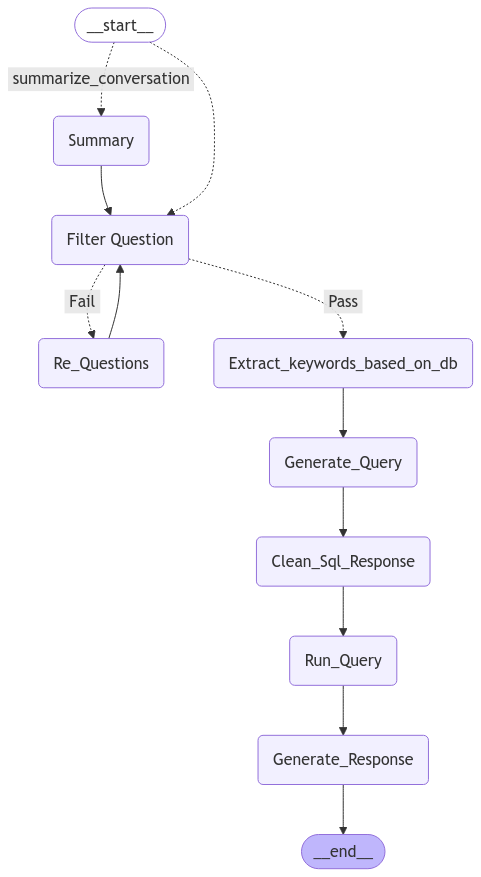

In [16]:
from IPython.display import Image, display
workflow_image = app.get_graph().draw_mermaid_png()
display(Image(workflow_image))

In [17]:
chunk

(AIMessageChunk(content='', additional_kwargs={}, response_metadata={'finish_reason': 'stop', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_72ed7ab54c'}, id='run-76995c01-cd21-4c95-b7ef-3c3879419694'),
 {'thread_id': '2',
  'langgraph_step': 6,
  'langgraph_node': 'Generate_Response',
  'langgraph_triggers': ['Run_Query'],
  'langgraph_path': ('__pregel_pull', 'Generate_Response'),
  'langgraph_checkpoint_ns': 'Generate_Response:47d5c675-3be8-2c09-32d8-73601737b280',
  'checkpoint_ns': 'Generate_Response:47d5c675-3be8-2c09-32d8-73601737b280',
  'ls_provider': 'openai',
  'ls_model_name': 'gpt-4o-mini',
  'ls_model_type': 'chat',
  'ls_temperature': 1.0})

In [18]:
print(db.get_table_info())


CREATE TABLE addresses (
	address_id INTEGER NOT NULL, 
	area_name VARCHAR(100), 
	latitude DOUBLE PRECISION, 
	longitude DOUBLE PRECISION, 
	created_at TEXT
)


CREATE TABLE crime_stats (
	stat_id INTEGER NOT NULL, 
	address_id INTEGER, 
	reference_date VARCHAR(100), 
	total_population DOUBLE PRECISION, 
	crime_category VARCHAR(100), 
	crime_subcategory VARCHAR(100), 
	incident_count INTEGER NOT NULL, 
	crime_rate DOUBLE PRECISION, 
	created_at TEXT
)


CREATE TABLE cultural_facilities (
	facility_id INTEGER NOT NULL, 
	address_id INTEGER, 
	facility_name VARCHAR(100), 
	facility_type VARCHAR(100), 
	created_at TEXT
)


CREATE TABLE cultural_festivals (
	festival_id INTEGER NOT NULL, 
	address_id INTEGER, 
	festival_name VARCHAR(100), 
	begin_date VARCHAR(100), 
	end_date VARCHAR(100), 
	created_at TEXT
)


CREATE TABLE favorites (
	id INTEGER NOT NULL, 
	user_uuid TEXT NOT NULL, 
	item_id INTEGER NOT NULL, 
	item_type VARCHAR(100), 
	name VARCHAR(100), 
	latitude DOUBLE PRECISION, 
